# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
# %pip install tqdm sklearn pandas

In [2]:
from math import ceil
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import collections
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import glob, os
import shutil
from object_detection.protos import input_reader_pb2
from object_detection.builders.dataset_builder import build as build_dataset

In [3]:
%matplotlib inline

In [4]:
def get_dataset(tfrecord_path, label_map='label_map.pbtxt'):
    """
    Opens a tf record file and create tf dataset
    args:
      - tfrecord_path [str]: path to a tf record file
      - label_map [str]: path the label_map file
    returns:
      - dataset [tf.Dataset]: tensorflow dataset
    """
    input_config = input_reader_pb2.InputReader()
    input_config.label_map_path = label_map
    input_config.tf_record_input_reader.input_path[:] = [tfrecord_path]
    
    dataset = build_dataset(input_config)
    return dataset

In [5]:
dataset = get_dataset("/waymo/processed/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2022-05-03 15:08:07.843123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 15:08:07.865107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 15:08:07.865285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-03 15:08:07.865647: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [6]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    size = len(list(batch))
    rows = ceil(size / 2)
    
    fig = plt.figure(figsize=(12., 12 * rows))
    grid = ImageGrid(
        fig, 
        111,  
        nrows_ncols=(rows, 2), 
        axes_pad=0.1, 
    )
    
    colormap = {
        1: [0, 0, 1], 
        2: [0, 1, 0], 
        4: [1, 0, 0]
    }

    for ax, im in zip(grid, batch):
        image = im["image"].numpy()
        image_size_x = image.shape[1]
        image_size_y = image.shape[0]
        
        ax.imshow(image)
        
        for bbox, label in zip(im['groundtruth_boxes'], im['groundtruth_classes']):
            bbox = bbox.numpy()
            label = label.numpy()
            x1 = bbox[1]
            x2 = bbox[3]
            y1 = bbox[0]
            y2 = bbox[2]
            rect = patches.Rectangle(
                (x1 * image_size_x, y1 * image_size_y), 
                (x2 - x1) * image_size_x, 
                (y2 - y1) * image_size_y, 
                linewidth=1, 
                edgecolor=colormap[label], 
                facecolor='none'
            )
            ax.add_patch(rect)


    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

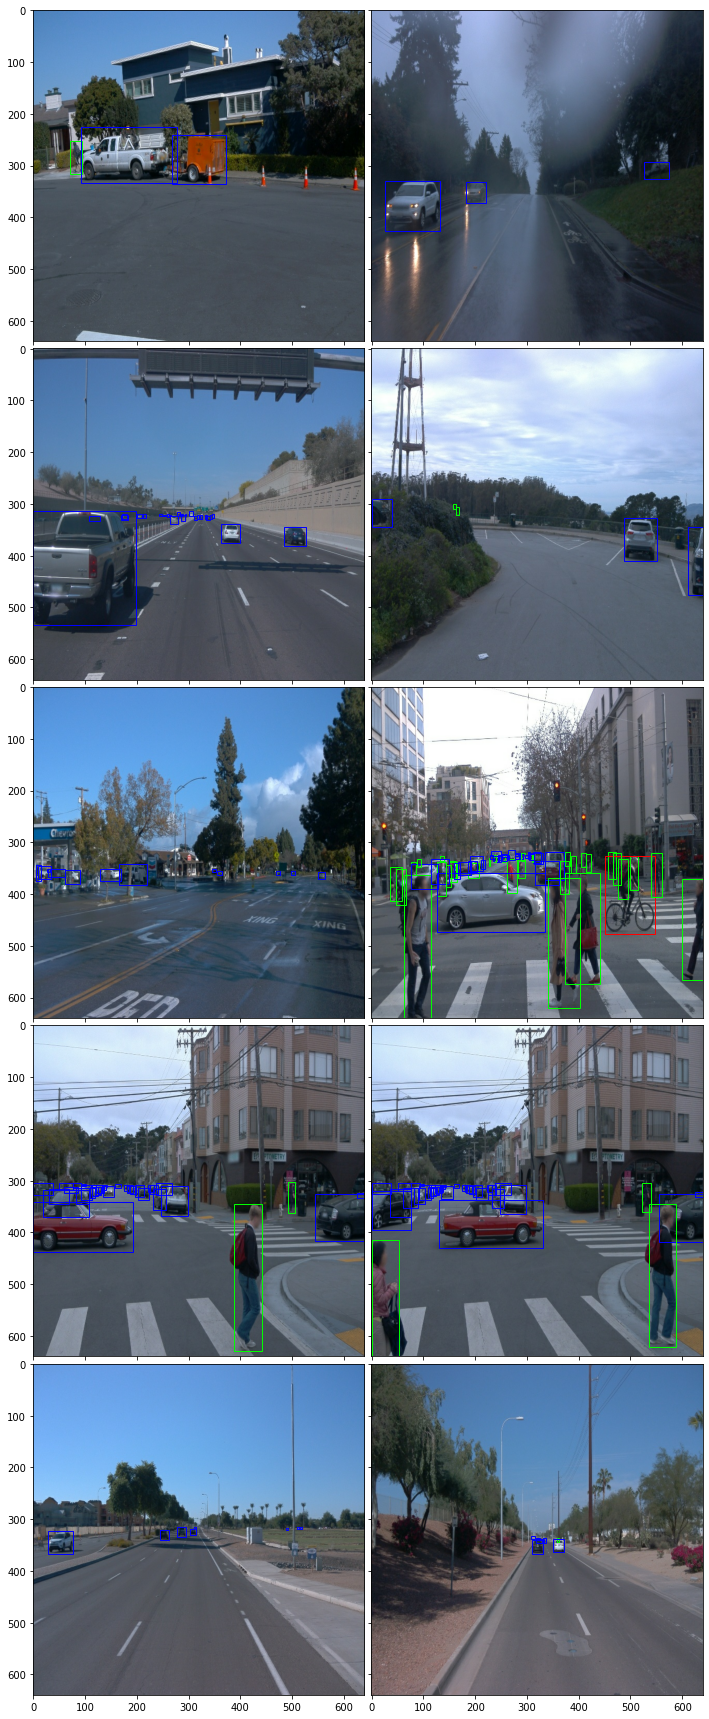

In [7]:
## STUDENT SOLUTION HERE
display_instances(dataset.shuffle(100).take(10))

# Additional EDA

## Get basic info about the dataset

In [8]:
!ls -la /waymo/processed/*.tfrecord | wc -l

100


The dataset consist of 100 tfrecord files. Each record contains i.a. an image and bounding boxes of labelled objects.

## Check labels classes combinations distribution of whole dataset and train/test/val splits

In [9]:
def calculate_label_distro(dataset):
    co = collections.Counter()
    for row in dataset:
        co.update(row["groundtruth_classes"].numpy())
    return co    

def get_distros(path, filter_files=None):
    distros = {}
    for data_file in tqdm(glob.glob(path)):
        if filter_files is not None:
            if data_file not in filter_files:
                print("skip")
                continue
        
        df = get_dataset(data_file).take(1000)
        co = calculate_label_distro(df)
        distros[data_file] = co

    return pd.DataFrame({x: dict(distros[x].items()) for x in distros}).T.fillna(0)

def add_has_value_column(df):
    ret = pd.DataFrame()
    for col in df.columns:
        ret[f"has_{col}"] = (df[col] > 0.0).astype("category")
    return ret

def merge_categorical_columns(df):
    return df.apply(lambda x: " ".join(x.astype(str)), axis=1).astype('category')

def prepare_split_files(path):
    df = get_distros(path)
    dd = merge_categorical_columns(add_has_value_column(df))
    dataset_train, dataset_test = train_test_split(dd.cat.codes, stratify=dd.cat.codes.values, test_size=0.1, random_state=1)
    dataset_train, dataset_val = train_test_split(dataset_train, stratify=dataset_train.values, test_size=0.11, random_state=1)
    return dataset_train, dataset_test, dataset_val

dataset_train, dataset_test, dataset_val = prepare_split_files("/waymo/processed/*.tfrecord")

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filen

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11119453952284076633_1369_940_1389_940_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11119453952284076633_1369_940_1389_940_with_camer

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10964956617027590844_1584_680_1604_680_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10231929575853664160_1160_000_1180_000_with_camera_labels

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11076364019363412893_1711_000_1731_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11076364019363412893_1711_000_1731_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Number of f

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10023947602400723454_1120_000_1140_000_with_camer

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1


#### Distribution of a whole dataset

In [10]:
full_distros = get_distros("/waymo/processed/*.tfrecord")

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filen

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10498013744573185290_1240_000_1260_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10275144660749673822_5755_561_5775_561_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11119453952284076633_1369_940_1389_940_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11119453952284076633_1369_940_1389_940_with_camer

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10964956617027590844_1584_680_1604_680_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10625026498155904401_200_000_220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11674150664140226235_680_000_700_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10231929575853664160_1160_000_1180_000_with_camera_labels

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11076364019363412893_1711_000_1731_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11076364019363412893_1711_000_1731_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_camera_labels.tfrecord']
INFO:tensorflow:Number of f

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10023947602400723454_1120_000_1140_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10023947602400723454_1120_000_1140_000_with_camer

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10770759614217273359_1465_000_1485_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1


In [11]:
full_distros_p = (full_distros.sum() / full_distros.sum().sum()).sort_index()
full_distros_p

1    0.767461
2    0.226768
4    0.005772
dtype: float64

Full dataset


<AxesSubplot:>

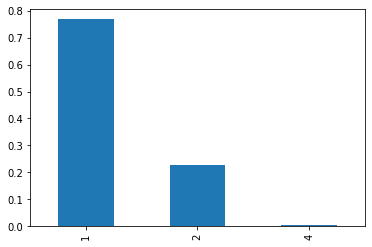

In [12]:
print("Full dataset")
full_distros_p.plot(kind="bar")

#### Distribution of a train dataset

In [13]:
train_distros = get_distros("/waymo/processed/*.tfrecord", filter_files=dataset_train.index.values)

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11928449532664718059_1200_000_1220_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10212406498497081993_5300_000_5320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11113047206980595400_2560_000_2580_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11113047206980595400_2560_000_2580_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number

INFO:tensorflow:Number of filenames to read: 1
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10664823084372323928_4360_000_4380_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10664823084372323928_4360_000_4380_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11799592541704458019_9828_750_9848_750_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11799592541704458019_9828_750_9848_750_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11489533038039664633_4820_000_4840_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11489533038039664633_4820_000_4840_000_

INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-1005081002024129653_5313_150_5333_150_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11847506886204460250_1640_000_1660_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11847506886204460250_1640_000_1660_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10485926982439064520_4980_000_5000_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10206293520369375008_2796_800_2816_800_with_c

INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10724020115992582208_7660_400_7680_400_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10724020115992582208_7660_400_7680_400_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11623618970700582562_2840_367_2860_367_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10599748131695282446_1380_000_1400_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of f

INFO:tensorflow:Number of filenames to read: 1
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11017034898130016754_697_830_717_830_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1


In [14]:
train_distros_p = (train_distros.sum() / train_distros.sum().sum()).sort_index()
train_distros_p

1    0.757862
2    0.236389
4    0.005749
dtype: float64

Train dataset


<AxesSubplot:>

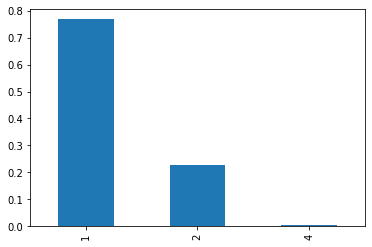

In [15]:
print("Train dataset")
full_distros_p.plot(kind="bar")

In [16]:
print(f"Dataset size: {len(dataset_train)}")

Dataset size: 80


#### Distribution of a test dataset

In [17]:
test_distros = get_distros("/waymo/processed/*.tfrecord", filter_files=dataset_test.index.values)

  0%|          | 0/100 [00:00<?, ?it/s]

skip
skip
skip
skip
skip
skip
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11219370372259322863_5320_000_5340_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11219370372259322863_5320_000_5340_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
skip
skip
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11718898130355901268_2300_000_2320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11718898130355901268_2300_000_2320_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10391312872392849784_4099_400_4119_400_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo

In [18]:
test_distros_p = (test_distros.sum() / test_distros.sum().sum()).sort_index()
test_distros_p

1    0.785948
2    0.208209
4    0.005843
dtype: float64

Test dataset


<AxesSubplot:>

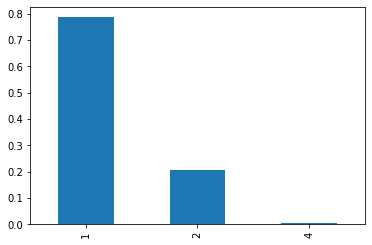

In [19]:
print("Test dataset")
test_distros_p.plot(kind="bar")

In [20]:
print(f"Dataset size: {len(dataset_test)}")

Dataset size: 10


#### Distribution of a val dataset

In [21]:
val_distros = get_distros("/waymo/processed/*.tfrecord", filter_files=dataset_val.index.values)

  0%|          | 0/100 [00:00<?, ?it/s]

skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-10723911392655396041_860_000_880_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
skip
skip
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-11355519273066561009_5323_000_5343_000_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-11355519273066561009_5323_000_5343_000_with_camera_labels.tfrecord']
INFO:tensorflow:Number of filenames to read: 1
skip
skip
INFO:tensorflow:Reading unweighted datasets: ['/waymo/processed/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/waymo/processed/segment-12174529769287588121_3848_440_3868_440_with_camera_labels.tfrecor

In [22]:
val_distros_p = (val_distros.sum() / val_distros.sum().sum()).sort_index()
val_distros_p

1    0.827050
2    0.167716
4    0.005234
dtype: float64

Validation dataset


<AxesSubplot:>

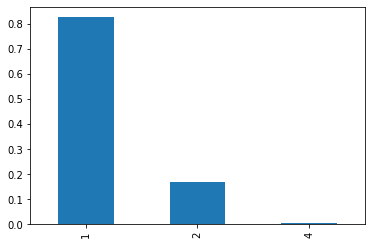

In [23]:
print("Validation dataset")
val_distros_p.plot(kind="bar")

In [24]:
print(f"Dataset size: {len(dataset_val)}")

Dataset size: 10
